In [6]:
# 아래 사이트 필사
# Start Here: A Gentle Introduction (https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
print(os.listdir('./'))

['data', 'home-credit-default-risk.ipynb']


In [9]:
train = pd.read_csv('./data/application_train.csv')
test = pd.read_csv('./data/application_test.csv')
train.shape

(307511, 122)

In [10]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis¶


## Examine the Distribution of the Target Column
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [11]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:ylabel='Frequency'>

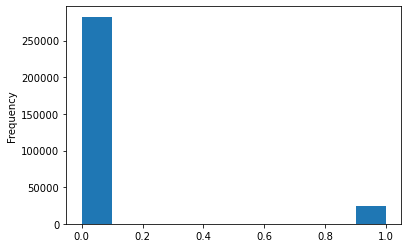

In [12]:
train['TARGET'].astype(int).plot.hist()

From this information, we see this is an **imbalanced class** problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can **weight the classes** by their representation in the data to reflect this imbalance.

## Examine Missing Values
Next we can look at the number and percentage of missing values in each column.

In [13]:
def missing_values_table(df) :
    mis_val = df.isnull().sum()
    mis_val_percent = mis_val/len(df)*100
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    mis_val_table_rename_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_rename_columns = mis_val_table_rename_columns[mis_val_table_rename_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)
    print('total columns : ' + str(df.shape[1]) + '\n' + 'missing values : ' + str(mis_val_table_rename_columns.shape[0]))
    return mis_val_table_rename_columns

In [14]:
missing_values = missing_values_table(train)
missing_values.head(20)

total columns : 122
missing values : 67


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.



## Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features. .

In [15]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [16]:
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!



## Encoding Categorical Variables
Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as LightGBM). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created.
* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns

레이블 인코딩의 문제는 범주에 임의의 순서를 부여한다는 것입니다. 각 범주에 할당된 값은 무작위이며 범주의 고유한 측면을 반영하지 않습니다. 위의 예에서 프로그래머는 4를, 데이터 과학자는 1을 받지만 동일한 프로세스를 다시 수행하면 레이블이 바뀌거나 완전히 다를 수 있습니다. 정수의 실제 할당은 임의적입니다. 따라서 레이블 인코딩을 수행할 때 모델은 기능의 상대 값(예: 프로그래머 = 4 및 데이터 과학자 = 1)을 사용하여 우리가 원하지 않는 가중치를 할당할 수 있습니다. 범주형 변수(예: 남성/여성)에 대해 고유한 값이 두 개뿐인 경우 레이블 인코딩은 괜찮지만 고유 범주가 2개 이상인 경우 원 핫 인코딩이 안전한 옵션입니다.

이러한 접근 방식의 상대적 장점에 대해 약간의 논쟁이 있으며 일부 모델은 문제 없이 레이블로 인코딩된 범주형 변수를 처리할 수 있습니다. 다음은 좋은 스택 오버플로 토론입니다. 클래스가 많은 범주형 변수의 경우 원-핫 인코딩이 범주에 임의의 값을 부과하지 않기 때문에 가장 안전한 접근 방식이라고 생각합니다. 원-핫 인코딩의 유일한 단점은 기능의 수(데이터 차원)가 많은 범주의 범주형 변수로 폭발할 수 있다는 것입니다. 이를 처리하기 위해 원-핫 인코딩을 수행한 후 PCA 또는 기타 차원 축소 방법을 수행하여 차원 수를 줄일 수 있습니다(여전히 정보를 보존하려고 시도하는 동안).


In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

## Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [17]:
le = LabelEncoder()
le_count=0

for col in train :
    if train[col].dtype == 'object' :
        if len(list(train[col].unique())) <= 2 :
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            le_count+=1

print('{} columns were label encoded'.format(le_count))

3 columns were label encoded


In [18]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print('train feature', train.shape)
print('test feature', test.shape)

train feature (307511, 243)
test feature (48744, 239)


### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [19]:
train_labels = train['TARGET']

train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

print('train feature', train.shape)
print('test feature', test.shape)

train feature (307511, 240)
test feature (48744, 239)


## Back to Exploratory Data Analysis¶
### Anomalies
One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the **statistics of a column using the describe method**. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [20]:
train['DAYS_BIRTH'].head()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [21]:
(train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?



In [22]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!



In [23]:
train['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

Text(0.5, 0, 'days employment')

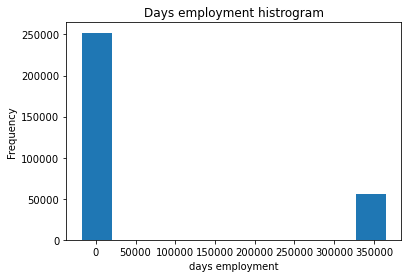

In [24]:
train['DAYS_EMPLOYED'].plot.hist(title='Days employment histrogram')
plt.xlabel('days employment')

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.



In [25]:
anom = train[train['DAYS_EMPLOYED']==365243]
non_anom = train[train['DAYS_EMPLOYED'] !=365243]
print('non-anomalies defalut : ',non_anom['TARGET'].mean()*100)
print('anomalies default : ', anom['TARGET'].mean()*100)
print('There are {} anomalies on DAYS_EMPLOYED'.format(len(anom)))

non-anomalies defalut :  8.65997453765215
anomalies default :  5.399646043269405
There are 55374 anomalies on DAYS_EMPLOYED


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

Text(0.5, 0, 'days employment')

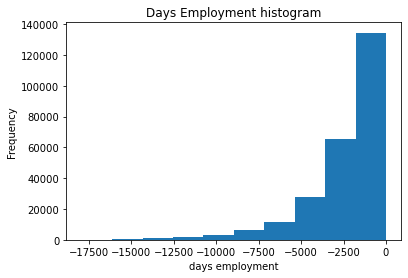

In [26]:
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED']==365243
train['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace=True)
train['DAYS_EMPLOYED'].plot.hist(title='Days Employment histogram')
plt.xlabel('days employment')


분포는 우리가 예상하는 것과 훨씬 더 일치하는 것으로 보이며, 이러한 값이 원래 비정상임을 모델에 알려주는 새 열도 만들었습니다. 열). 데이터 프레임에 DAYS가 있는 다른 열은 명백한 이상값 없이 예상한 것과 같습니다.

매우 중요한 메모로, 훈련 데이터에 대해 수행하는 모든 작업은 테스트 데이터에도 수행해야 합니다. 테스트 데이터에서 새 열을 만들고 기존 열을 np.nan으로 채우도록 합시다.

In [27]:
test['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED_ANOM'] == 365243
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)

### Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the *.corr* dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

In [28]:
correlations = train.corr()['TARGET'].sort_values()

print('Most Positive Correlations : \n', correlations.tail(15))
print('\n Most Negative Correlations : \n', correlations.head(15))

Most Positive Correlations : 
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

 Most Neg

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.



### Effect of Age on Repayment¶


In [29]:
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830984513

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

In [30]:
# plt.style.use('fivethirtyeight')
# plt.hist(train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
# plt.title('Age of client')
# plt.xlabel('Age')
# plt.ylabel('Count')

그 자체로 연령 분포는 모든 연령이 합리적이므로 이상치가 없다는 것 외에는 많은 것을 말해주지 않습니다. 대상에 대한 연령의 영향을 시각화하기 위해 다음으로 대상 값으로 색칠된 커널 밀도 추정 플롯(kernel density estimation plot, KDE)을 만듭니다. 커널 밀도 추정 플롯은 단일 변수의 분포를 보여주며 평활 히스토그램으로 생각할 수 있습니다(각 데이터 포인트에서 커널, 일반적으로 가우스를 계산한 다음 모든 개별 커널을 평균화하여 하나의 평활한 히스토그램을 생성합니다. 곡선). 이 그래프에는 seaborn kdeplot을 사용합니다.


In [31]:
# plt.figure(figsize=(10,8))

# sns.kdeplot(train.loc[train['TARGET']==0, 'DAYS_BIRTH'] / 365, label = 'target==0')
# sns.kdeplot(train.loc[train['TARGET']==1, 'DAYS_BIRTH'] / 365, label = 'target==1')
# plt.xlabel('age')
# plt.ylabel('density')
# plt.title('distribution of ages')
# plt.legend()

target == 1 곡선은 범위의 더 어린 쪽 끝으로 기울어집니다. 이것이 유의미한 상관관계는 아니지만(-0.07 상관 계수), 이 변수는 대상에 영향을 미치기 때문에 기계 학습 모델에서 유용할 것 같습니다. 이 관계를 다른 방식으로 살펴보겠습니다. 연령대별 평균 대출 상환 실패.

이 그래프를 만들기 위해 먼저 연령 범주를 각각 5년 단위로 자릅니다. 그런 다음 각 빈에 대해 대상의 평균 값을 계산하여 각 연령 범주에서 상환되지 않은 대출 비율을 알려줍니다.

In [32]:
age_data = train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70, num=11))
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


In [33]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


In [34]:
# plt.figure(figsize=(8,8))
# plt.bar(age_groups.index.astype(str), 100* age_groups['TARGET'])
# plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
# plt.title('Failure to Repay by Age Group')

분명한 추세가 있습니다. 젊은 신청자는 대출을 상환하지 않을 가능성이 더 큽니다! 연체율은 최연소 3세 10% 이상, 고령 5% 미만이다.

이것은 은행에서 직접 사용할 수 있는 정보입니다. 젊은 고객은 대출금을 상환할 가능성이 적기 때문에 더 많은 지침이나 재무 계획 팁을 제공받아야 합니다. 그렇다고 해서 은행이 어린 고객들을 차별해야 한다는 의미는 아니지만, 젊은 고객들이 제때 지불할 수 있도록 예방 조치를 취하는 것이 현명할 것입니다.

### Exterior Sources
The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [35]:
ext_data = train[['TARGET','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


In [36]:
# plt.figure(figsize=(8,6))
# sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, annot=True, vmin=-0.25, vmax=0.6)
# plt.title('Correlation heatmap')

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

In [37]:
# plt.figure(figsize=(10,12))

# for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']) :
#     plt.subplot(3,1,i+1)
#     sns.kdeplot(train.loc[train['TARGET']==0, source], label='target==0')
#     sns.kdeplot(train.loc[train['TARGET']==1, source], label='target==1')
#     plt.title('distribution of {} by Target'.format(source))
#     plt.xlabel('{}'.format(source))
#     plt.legend()
# plt.tight_layout(h_pad=2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

### Pairs Plot
As a final exploratory plot, we can make a pairs plot of the EXT_SOURCE variables and the DAYS_BIRTH variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

In [38]:
# plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()
# plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']
# plot_data = plot_data.dropna().loc[:100000,:]

# grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False, hue='TARGET', vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# grid.map_upper(plt.scatter, alpha=0.2)
# grid.map_diag(sns.kdeplot)
# grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r)
# plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05)


이 그림에서 빨간색은 상환되지 않은 대출을 나타내고 파란색은 상환된 대출을 나타냅니다. 데이터 내에서 다양한 관계를 볼 수 있습니다. EXT_SOURCE_1과 DAYS_BIRTH(또는 이에 상응하는 YEARS_BIRTH) 사이에 적당한 양의 선형 관계가 있는 것으로 보이며, 이는 이 기능이 클라이언트의 연령을 고려할 수 있음을 나타냅니다.


# Feature Engineering
Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

* Polynomial features
* Domain knowledge features

## Polynomial Features
One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x EXT_SOURCE_2^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

Jake VanderPlas writes about polynomial features in his excellent book Python for Data Science for those who want more information.

In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

In [39]:
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# create polynomial object
poly_transformer = PolynomialFeatures(degree=3)

In [40]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
poly_features.shape

(307511, 35)

This creates a considerable number of new features. To get the names we have to use the polynomial features get_feature_names method.

In [41]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [42]:
# create dataframe of the features
poly_features = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

# add in the target
poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [43]:
# put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, columns=poly_transformer.get_feature_names(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))

# merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# merge polynomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# align the dataframe
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis=1)

print(train_poly.shape, '\t', test_poly.shape)

(307511, 275) 	 (48744, 275)


## Domain Knowledge Features
Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and his great script for exploring these features.

In [44]:
train_domain = train.copy()
test_domain = test.copy()

In [45]:
train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']

In [46]:
test_domain['CREDIT_INCOME_PERCENT'] = test_domain['AMT_CREDIT'] / test_domain['AMT_INCOME_TOTAL']
test_domain['ANNUITY_INCOME_PERCENT'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_INCOME_TOTAL']
test_domain['CREDIT_TERM'] = test_domain['AMT_ANNUITY'] / test_domain['AMT_CREDIT']
test_domain['DAYS_EMPLOYED_PERCENT'] = test_domain['DAYS_EMPLOYED'] / test_domain['DAYS_BIRTH']

In [47]:
train_domain

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,1,0,1,0,1,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,1,0,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,1,0,1,0,0,False,1.617143,0.174971,0.108198,-0.025303
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,1,0,1,0,0,True,3.743750,0.166687,0.044524,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,0,0,1,0,0,False,4.429176,0.195941,0.044239,-0.529266
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,1,0,1,0,1,False,2.164368,0.118158,0.054592,-0.400134


### Visualize New Variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

In [48]:
# plt.figure(figsize=(12,20))

# for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
#     plt.subplot(4,1,i+1)
#     sns.kdeplot(train_domain.loc[train_domain['TARGET']==0,feature], label = 'target==0')
#     sns.kdeplot(train_domain.loc[train_domain['TARGET']==1,feature], label = 'target==1')
    
#     plt.title('ditribution of {} by target value'.format(feature))
#     plt.xlabel('{}'.format(feature))
#     plt.ylabel('density')


#     plt.tight_layout(h_pad=2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!



# Baseline
For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.



## Logistic Regression Implementation
Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both An Introduction to Statistical Learning and Hands-On Machine Learning with Scikit-Learn and TensorFlow. Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective!

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [49]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# drop 'target' from training data
if 'TARGET' in train :
    train_input = train.drop(columns=['TARGET'])
else :
    train_input = train.copy()
    
# feature names
features = list(train_input.columns)

test_input = test.copy()

# imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# scaler to 0-1
scaler = MinMaxScaler(feature_range=(0,1))

# fit on the training data
imputer.fit(train_input)

# transform both train, test data on missing values
train_input = imputer.transform(train_input)
test_input = imputer.transform(test_input)

# transform both train, test data on scaler
scaler.fit(train_input)
train_input = scaler.transform(train_input)
test_input = scaler.transform(test_input)

print(train_input.shape, '\t', test_input.shape)

(307511, 240) 	 (48744, 240)


We will use LogisticRegressionfrom Scikit-Learn for our first model. The only change we will make from the default model settings is to lower the regularization parameter, C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default LogisticRegression, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using .fit and then we make predictions on the testing data using .predict_proba (remember that we want probabilities and not a 0 or 1).

In [50]:
# from sklearn.linear_model import LogisticRegression

# # make the model with the specified regularization parameter
# log_reg = LogisticRegression(C=0.0001)

# # Train on the training data
# log_reg.fit(train_input,train_labels)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model predict.proba method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [51]:
# # make the predictions
# # select the 2nd column for submission
# log_reg_pred = log_reg.predict_proba(test_input)[:,1]

The predictions must be in the format shown in the sample_submission.csv file, where there are only two columns: SK_ID_CURR and TARGET. We will create a dataframe in this format from the test set and the predictions called submit.

In [52]:
# # submission dataframe
# submit = test[['SK_ID_CURR']]
# submit['TARGET'] = log_reg_pred
# submit.head()

The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky.

In [53]:
# # save the submission to csv file 
# submit.to_csv('submission.csv', index = False)

The submission has now been saved to the virtual environment in which our notebook is running. To access the submission, at the end of the notebook, we will hit the blue Commit & Run button at the upper right of the kernel. This runs the entire notebook and then lets us download any files that are created during the run.

Once we run the notebook, the files created are available in the Versions tab under the Output sub-tab. From here, the submission files can be submitted to the competition or downloaded. Since there are several models in this notebook, there will be multiple output files.

**The logistic regression baseline should score around 0.671 when submitted.**

## Improved Model: Random Forest
To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [54]:
# from sklearn.ensemble import RandomForestClassifier

# random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs=-1)

In [55]:
# random_forest.fit(train_input, train_labels)

# # extract feature importances
# feature_importance_values = random_forest.feature_importances_
# feature_importances = pd.DataFrame({'feature' : features, 'importance' : feature_importance_values})

# # # make prediction on test data
# predictions = random_forest.predict_proba(test_input)[:,1]

In [56]:
# # make a submission
# submit = test[['SK_ID_CURR']]
# submit['TARGET'] = predictions

# submit.to_csv('random_forest_baseline.csv',index=False)

These predictions will also be available when we run the entire notebook.

**This model should score around 0.678 when submitted.**

### Make Predictions using Engineered Features
The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [57]:
# poly_features_names = list(train_poly.columns)

# # imputer
# imputer = SimpleImputer(strategy = 'median')

# poly_features = imputer.fit_transform(train_poly)
# poly_features_test = imputer.transform(test_poly)

# # scaler
# scaler = MinMaxScaler(feature_range=(0,1))

# poly_features = scaler.fit_transform(poly_features)
# poly_features_test = scaler.transform(poly_features_test)

# random_forest_poly = RandomForestClassifier(n_estimators=100, random_state = 50, verbose =1, n_jobs=-1)

In [58]:
# # train on training data
# random_forest_poly.fit(poly_features, train_labels)

# # prediction on test data
# predictions = random_forest_poly.predict_proba(poly_features_test)[:,1]

In [59]:
# # Make a submission dataframe
# submit = test[['SK_ID_CURR']]
# submit['TARGET'] = predictions

# # Save the submission dataframe
# submit.to_csv('random_forest_baseline_engineered.csv', index = False)

This model scored 0.678 when submitted to the competition, exactly the same as that without the engineered features. Given these results, it does not appear that our feature construction helped in this case.

### Testing Domain Features
Now we can test the domain features we made by hand.

In [60]:
# train_domain = train_domain.drop(columns='TARGET')

# domain_feature_names = list(train_domain.columns)

# # imputer
# imputer = SimpleImputer(strategy='median')

# domain_features = imputer.fit_transform(train_domain)
# domain_features_test = imputer.transform(test_domain)

# # scaler
# scaler = MinMaxScaler(feature_range=(0,1))

# domain_features = scaler.fit_transform(domain_features)
# domain_features_test = scaler.transform(domain_features_test)

# random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state=50, verbose=1, n_jobs=-1)

# # train on train data
# random_forest_domain.fit(domain_features, train_labels)

# # extract feature importances
# feature_importance_values_domain = random_forest_domain.feature_importances_
# feature_importances_domain = pd.DataFrame({'feature' : domain_feature_names, 'importance' : feature_importance_values_domain})

# # predition on test data
# predictions = random_forest_domain.predict_proba(domain_features_test)[:,1]

In [61]:
# # make a submission
# submit = test[['SK_ID_CURR']]
# submit['TARGET'] = predictions

# submit.to_csv('submission.csv',index = False)

**This scores 0.679** when submitted which probably shows that the engineered features do not help in this model (however they do help in the Gradient Boosting Model at the end of the notebook).

In later notebooks, we will do more feature engineering by using the information from the other data sources. From experience, this will definitely help our model!

### Model Interpretation: Feature Importances
As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the EXT_SOURCE and the DAYS_BIRTH. We may use these feature importances as a method of dimensionality reduction in future work.

In [62]:
def plot_feature_importances(df) :
    
    # sort feature according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    
    # Normalize the feature importance to add up to 1
    df['importance_normalized'] = df['importance']/df['importance'].sum()
    
    # make a horizontal bar chart 
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    plt.xlabel('Normalized importance')
    plt.title('feature importances')
    plt.show()
    
    return df

In [63]:
# # feature importance for defalut 
# feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with EXT_SOURCE and DAYS_BIRTH. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions.

In [64]:
# feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

# Conclusions
In this notebook, we saw how to get started with a Kaggle machine learning competition. We first made sure to understand the data, our task, and the metric by which our submissions will be judged. Then, we performed a fairly simple EDA to try and identify relationships, trends, or anomalies that may help our modeling. Along the way, we performed necessary preprocessing steps such as encoding categorical variables, imputing missing values, and scaling features to a range. Then, we constructed new features out of the existing data to see if doing so could help our model.

Once the data exploration, data preparation, and feature engineering was complete, we implemented a baseline model upon which we hope to improve. Then we built a second slightly more complicated model to beat our first score. We also carried out an experiment to determine the effect of adding the engineering variables.

We followed the general outline of a machine learning project:

Understand the problem and the data
Data cleaning and formatting (this was mostly done for us)
Exploratory Data Analysis
Baseline model
Improved model
Model interpretation (just a little)
Machine learning competitions do differ slightly from typical data science problems in that we are concerned only with achieving the best performance on a single metric and do not care about the interpretation. However, by attempting to understand how our models make decisions, we can try to improve them or examine the mistakes in order to correct the errors. In future notebooks we will look at incorporating more sources of data, building more complex models (by following the code of others), and improving our scores.

I hope this notebook was able to get you up and running in this machine learning competition and that you are now ready to go out on your own - with help from the community - and start working on some great problems!

Running the notebook: now that we are at the end of the notebook, you can hit the blue Commit & Run button to execute all the code at once. After the run is complete (this should take about 10 minutes), you can then access the files that were created by going to the versions tab and then the output sub-tab. The submission files can be directly submitted to the competition from this tab or they can be downloaded to a local machine and saved. The final part is to share the share the notebook: go to the settings tab and change the visibility to Public. This allows the entire world to see your work!

## Follow-up Notebooks
For those looking to keep working on this problem, I have a series of follow-up notebooks:

Manual Feature Engineering Part One
Manual Feature Engineering Part Two
Introduction to Automated Feature Engineering
Advanced Automated Feature Engineering
Feature Selection
Intro to Model Tuning: Grid and Random Search
As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will

# Just for Fun: Light Gradient Boosting Machine
Now (if you want, this part is entirely optional) we can step off the deep end and use a real machine learning model: the gradient boosting machine using the LightGBM library! The Gradient Boosting Machine is currently the leading model for learning on structured datasets (especially on Kaggle) and we will probably need some form of this model to do well in the competition. Don't worry, even if this code looks intimidating, it's just a series of small steps that build up to a complete model. I added this code just to show what may be in store for this project, and because it gets us a slightly better score on the leaderboard. In future notebooks we will see how to work with more advanced models (which mostly means adapting existing code to make it work better), feature engineering, and feature selection. See you in the next notebook!

In [99]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds=5) :
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns=['SK_ID_CURR','TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    # One-Hot encoding
    if encoding == 'ohe' :
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # align the dataframe
        features, test_features = features.align(test_features, join='inner', axis=1)
        
        cat_indices = 'auto'
    
    # Label encoding
    elif encoding == 'le' :
        label_encoder = LabelEncoder()
        
        # list for storing categorical indices
        cat_indices = []
        
        for i, col in enumerate(features) :
            if features[col].dtype == 'object' :
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                
                # record the categorical indices
                cat_indices.append(i)
    
    else :
        raise ValueError("encoding must be either 'ohe' or 'le'")
        
    print('training data shape : ', features.shape)
    print('test data shape : ', test_features.shape)
    
    features_name = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(features_name))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features) :
        # training, validation data 
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # create model
        model = lgb.LGBMClassifier(n_estimators =10000, objective = 'binary', class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, n_jobs=-1, random_state = 50)
        # train model
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features,valid_labels),(train_features,train_labels)],
                  eval_names = ['valid','train'], categorical_feature = cat_indices, early_stopping_rounds = 100, verbose=200)
        
        # record best iteration
        best_iteration = model.best_iteration_
        
        # record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # make prediction
        test_predictions += model.predict_proba(test_features, num_interation = best_iteration)[:, 1] / k_fold.n_splits
        
        # record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        # record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # make submission 
    submission = pd.DataFrame({'SK_ID_CURR' : test_ids, 'TARGET' : test_predictions})
    
    # feature importance dataframe
    feature_importances = pd.DataFrame({'feature' : features_name, 'importance' : feature_importance_values})
    
    # overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # add the overall scores to metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold' : fold_names, 'train' : train_scores, 'valid' : valid_scores})
    
    return submission, feature_importances, metrics

In [66]:
submission, feature_importances, metrics = model(train, test)
print(metrics)

training data shape :  (307511, 238)
test data shape :  (48744, 238)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797263	train's binary_logloss: 0.549253	valid's auc: 0.754613	valid's binary_logloss: 0.564614
Early stopping, best iteration is:
[279]	train's auc: 0.80977	train's binary_logloss: 0.537089	valid's auc: 0.755213	valid's binary_logloss: 0.556854
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.797071	train's binary_logloss: 0.54948	valid's auc: 0.75653	valid's binary_logloss: 0.565188
Early stopping, best iteration is:
[225]	train's auc: 0.801202	train's binary_logloss: 0.545443	valid's auc: 0.756755	valid's binary_logloss: 0.562718
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.796361	train's binary_logloss: 0.550805	valid's auc: 0.762559	valid's binary_logloss: 0.565105
Early stopping, best iteration is:
[245]	train's auc: 0.803671	train's binary_logloss: 0.543801	va

In [67]:
# fi_sorted = plot_feature_importances(feature_importances)

In [68]:
# submission.to_csv('baseline_lgb.csv', index = False)

This submission should **score about 0.735** on the leaderboard. We will certainly best that in future work!



In [69]:
# train_domain['TARGET'] = train_labels

# submission_domain, fi_domain, metrics_domain = model(train_domain, test_domain)
# print(metrics_domain)

In [70]:
# fi_sorted = plot_feature_importances(fi_domain)

Again, we see tha some of our features made it into the most important. Going forward, we will need to think about whatother domain knowledge features may be useful for this problem (or we should consult someone who knows more about the financial industry!

In [71]:
# submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

This model **scores about 0.754** when submitted to the public leaderboard indicating that the domain features do improve the performance! Feature engineering is going to be a critical part of this competition (as it is for all machine learning problems)!

In [113]:
# xgboost로 구현해보기

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import gc

def xgbmodel(features, test_features, encoding = 'ohe', n_folds=5) :
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    labels = features['TARGET']
    
    features = features.drop(columns=['SK_ID_CURR','TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    # One-Hot encoding
    if encoding == 'ohe' :
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # align the dataframe
        features, test_features = features.align(test_features, join='inner', axis=1)
        
        cat_indices = 'auto'
    
    # Label encoding
    elif encoding == 'le' :
        label_encoder = LabelEncoder()
        
        # list for storing categorical indices
        cat_indices = []
        
        for i, col in enumerate(features) :
            if features[col].dtype == 'object' :
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                
                # record the categorical indices
                cat_indices.append(i)
    
    else :
        raise ValueError("encoding must be either 'ohe' or 'le'")
        
    print('training data shape : ', features.shape)
    print('test data shape : ', test_features.shape)
    
    features_name = list(features.columns)
    
    features = np.array(features)
    test_features = np.array(test_features)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    feature_importance_values = np.zeros(len(features_name))
    
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features) :
        # training, validation data 
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # create model
        model = xgb.XGBClassifier(n_estimators =10000, objective = 'binary:logistic', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, n_jobs=-1, random_state = 50)
        # train model
        model.fit(train_features, train_labels, eval_metric = 'auc', 
                  eval_set = [(valid_features,valid_labels),(train_features,train_labels)], early_stopping_rounds = 100, verbose=200)
        
        # record best iteration
        best_iteration = model.best_iteration
        
        # record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # make prediction
        test_predictions += model.predict_proba(test_features, num_interation = best_iteration)[:, 1] / k_fold.n_splits
        
        # record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:,1]
        
        # record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # make submission 
    submission = pd.DataFrame({'SK_ID_CURR' : test_ids, 'TARGET' : test_predictions})
    
    # feature importance dataframe
    feature_importances = pd.DataFrame({'feature' : features_name, 'importance' : feature_importance_values})
    
    # overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # add the overall scores to metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold' : fold_names, 'train' : train_scores, 'valid' : valid_scores})
    
    return submission, feature_importances, metrics

In [114]:
submission_xgb, feature_importances_xgb, metrics_xgb = xgbmodel(train, test)
print(metrics_xgb)

training data shape :  (307511, 238)
test data shape :  (48744, 238)
[0]	validation_0-auc:0.71074	validation_1-auc:0.72111
[200]	validation_0-auc:0.75361	validation_1-auc:0.80962
[400]	validation_0-auc:0.75567	validation_1-auc:0.84364
[600]	validation_0-auc:0.75531	validation_1-auc:0.86911
[800]	validation_0-auc:0.75428	validation_1-auc:0.89004
[1000]	validation_0-auc:0.75282	validation_1-auc:0.90759
[1200]	validation_0-auc:0.75205	validation_1-auc:0.92291


KeyboardInterrupt: 

xgboost training시 overfitting 문제 생김 : 

[0]	validation_0-auc:0.71074	validation_1-auc:0.72111

[200]	validation_0-auc:0.75361	validation_1-auc:0.80962

[400]	validation_0-auc:0.75567	validation_1-auc:0.84364

[600]	validation_0-auc:0.75531	validation_1-auc:0.86911

[800]	validation_0-auc:0.75428	validation_1-auc:0.89004

[1000]	validation_0-auc:0.75282	validation_1-auc:0.90759

[1200]	validation_0-auc:0.75205	validation_1-auc:0.92291

시간도 오래걸림 여기까지가 5m 40s, 

lgb는 다 끝나는 시간이 1m 16s 